In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import berserk
import chess
import xycmap

In [3]:
client = berserk.Client()

In [4]:
player = "devinpleuler"

In [5]:
start = berserk.utils.to_millis(datetime(2023, 1, 1))
end = berserk.utils.to_millis(datetime(2024, 1, 1))
gen = client.games.export_by_player(player, since=start, until=end)

In [6]:
games = list(gen)

In [7]:
total_games = float(len(games))

In [8]:
occupancy = {True: {}, False: {}}
for g in games:
    if g['source'] == "pool":
        white_player = g['players']['white']['user']['name']
        black_player = g['players']['black']['user']['name']

        if player in [white_player, black_player]:
            moves = g['moves'].split(" ")
            board = chess.Board()
            for i, m in enumerate(moves):
                mov_num = i
                for k, piece in board.piece_map().items():
                        if mov_num not in occupancy[piece.color]:
                            occupancy[piece.color][mov_num] = {}
                        if k not in occupancy[piece.color][mov_num]:
                            occupancy[piece.color][mov_num][k] = 0
                        occupancy[piece.color][mov_num][k] += 1
                board.push_san(m)

In [9]:
densities = {}
for color, moves in occupancy.items():
    for mov_num, locations in moves.items():
        density = {k: 0 for k in range(64)}
        for k, v in locations.items():
            density[k] += v
        densities[(color, mov_num)] = density    

In [10]:
corner_colors = ("#e8e8e8", "#64acbe", "#c85a5a", "#574249")
n = (5, 5)
cmap = xycmap.custom_xycmap(corner_colors=corner_colors, n=n)

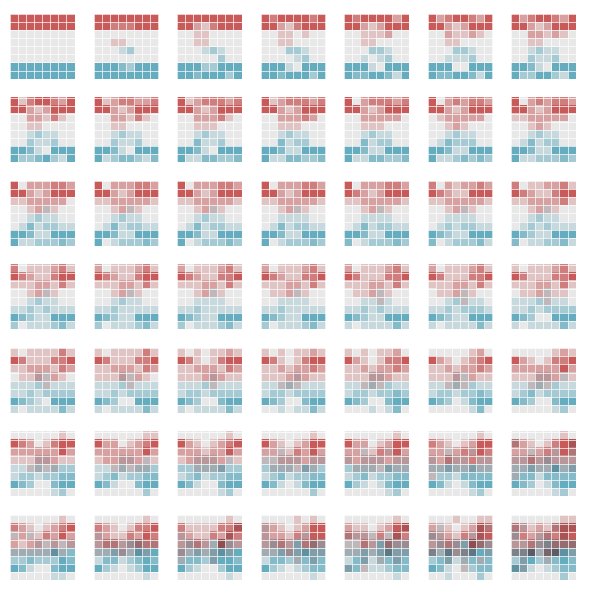

In [11]:
rows = 7
fig, axes = plt.subplots(nrows=rows, ncols=rows, figsize=(6, 6))

for i in range(rows * rows):
    j = i*2
    flat_white = [(float(v * 1.5)/total_games) for k, v in densities[(True, j)].items()] 
    flat_black = [(float(v * 1.5)/total_games) for k, v in densities[(False, j)].items()]
    
    colors = xycmap.bivariate_color(sx=pd.Series(flat_white), sy=pd.Series(flat_black), cmap=cmap)

    flat = []
    for r,g,b,a in colors.values:
        flat.append(np.array([r,g,b,a]))

    square = np.reshape(np.array(flat),(8,8,4))
    
    ax = axes[i // rows, i % rows]
    ax.imshow(square, alpha=1.0, interpolation='nearest')
    
    x_ticks = np.arange(-0.5, square.shape[1], 1)
    y_ticks = np.arange(-0.5, square.shape[0], 1)
    ax.set_xticks(x_ticks, minor=True)
    ax.set_yticks(y_ticks, minor=True)
    ax.grid(which='minor', color='white', lw=0.5)

    ax.set_xlim(-0.5, square.shape[1])
    ax.set_ylim(-0.5, square.shape[0])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(which='minor', length=0)

    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    for _, spine in ax.spines.items():
        spine.set_linewidth(0)

plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.tight_layout()
plt.savefig("lichess_{}.jpeg".format(player), format='jpeg', dpi=300)